In [1]:
import pandas as pd

In [ ]:
ds = pd.read_csv('data/DS_with_one_hot.csv', delimiter=';')
ds.head()

In [ ]:
ds.describe()

In [ ]:
ds.set_index('id', inplace=True)
ds['totalAddressValue'] = ds['propertyValue'] + ds['groundValue']

In [ ]:
# Drop rows where property or ground value is 0
ds_simple = ds.loc[(ds['propertyValue'] != 0.0) & (ds['groundValue'] != 0.0)]

# Dropping useless columns
ds_simple = ds_simple.drop(columns=[
    'evaluationYear',
    'groundValue',
    'propertyValue',
    'propertyTax',
    'groundTax',
    'totalAddressTax',
    'address',
    'house_nr',
    'street_name',
    'city_name'
])

# Filling area columns with 0 if nan
area_columns = [col for col in ds_simple.columns if 'area' in col.lower()]
ds_simple[area_columns] = ds_simple[area_columns].fillna(0)

# Filling other columns with default 0 if nan
misc_columns_with_nans = [
    'locationOnLakeTerritory',
    'numberOfFloors',
    'shelterSpaces'
]
ds_simple[misc_columns_with_nans] = ds_simple[misc_columns_with_nans].fillna(0)

ds_without_nans = ds_simple.dropna()

In [ ]:
ds_simple.loc[ds_simple.isna().any(axis=1)]

In [ ]:
828874/len(ds_simple),len(ds_simple) - 828874

In [ ]:
ds_without_nans.to_csv('data/DS_totalAddressValue_no_nans.csv')

# Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
ds_without_nans = pd.read_csv('data/DS_totalAddressValue_no_nans.csv', index_col='id')

In [4]:
# Prediction variable
prediction_property = 'totalAddressValue'
total_address_values = ds_without_nans[prediction_property]

# Feature data
feature_names = ds_without_nans.columns[ds_without_nans.columns != prediction_property]
feature_data = ds_without_nans[feature_names]


In [ ]:
scaler = StandardScaler()
normalized_feature_data = scaler.fit_transform(feature_data)

In [6]:
len(total_address_values)

526117

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_components = 10 # len(feature_names)
pca = PCA(n_components=n_components)
transformed_ds = pca.fit_transform(normalized_feature_data)
components = pca.components_

In [ ]:
n_plotting_components = n_components
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i+1, y[i], f"{y[i]:.2f} %", ha = 'center')
		
variances = pca.explained_variance_
variance_ratios = pca.explained_variance_ratio_
print("Component variances:",variances[:n_plotting_components])
print("Component percentages/ratios:",variance_ratios[:n_plotting_components])

component_percentage = variance_ratios[:n_plotting_components]*100
plt.bar(range(1,n_plotting_components +1), component_percentage)
addlabels(range(1,n_plotting_components +1), component_percentage)
plt.title("Details explained per component")
plt.show()

# Regression analysis

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
LR_model = LinearRegression().fit(
    normalized_feature_data,
    total_address_values
)

In [ ]:
# Coefficient of determination
LR_model.score(normalized_feature_data, total_address_values)
# Not looking great

In [ ]:
LR_coefficients = LR_model.coef_
feature_coef_map = sorted(
    [{'feature':feature,'coef':coef} for feature, coef in zip(feature_names, LR_coefficients)],
    key=lambda x: x['coef'],
    reverse=True
)
sorted_features = [x['feature'] for x in feature_coef_map]
sorted_coefs = [x['coef'] for x in feature_coef_map]

n_plotting_features = 15
plt.bar(
    sorted_features[:n_plotting_features],
    sorted_coefs[:n_plotting_features]
)
plt.xticks(rotation=90)
plt.show()

In [ ]:
LR_predictions = LR_model.predict(normalized_feature_data)
pd.DataFrame({'actual': total_address_values, 'prediction':LR_predictions})

## Poly regression
As the coefficient of determination was so low for the LR

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)\
    .fit_transform(normalized_feature_data)
poly_model = LinearRegression().fit(poly_features, total_address_values)

In [ ]:
# Coefficient of determination
poly_model.score(poly_features, total_address_values)

## DBSCAN

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [10]:
# Determining hyperparameters
# https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
NN_model = NearestNeighbors(n_neighbors=2).fit(feature_data)
distances, indices = NN_model.kneighbors(feature_data)

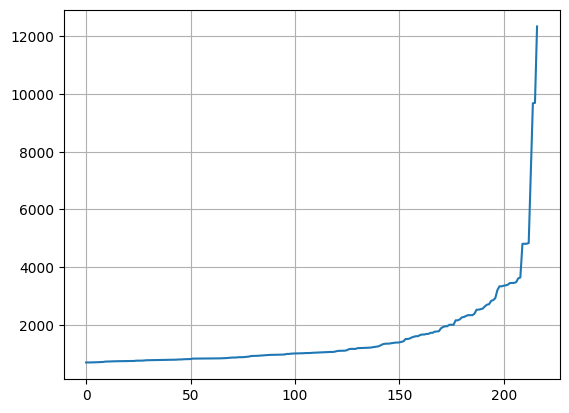

In [45]:
plt.plot(np.sort(distances)[525_900:])
plt.grid()
plt.show()

In [6]:
eps = 3900

In [50]:
distance_stats = pd.DataFrame(distances).describe()
distance_stats

,0
count,526117.000000
mean,19.926792
std,49.130484
min,0.000000
25%,8.246211
50%,13.379088
75%,22.000000
max,12344.900526


In [53]:
len(distances[distances>eps]) # Outliers

8

In [7]:
min_samples = 2*len(feature_names)

In [54]:
# Fitting DBSCAN 
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(feature_data)

In [ ]:
db_clusterings = dbscan.labels_
np.save('data/DBSCAN_clusterings.npy', db_clusterings)

In [ ]:
import gc
gc.collect()